In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_start = '2010-01-01'
train_end = '2017-12-31'
test_end = '2020-12-31'

## Read master_ds_v1_NoNA

In [ ]:
df=pd.read_csv('gdrive/My Drive/master_ds_v1_NoNA.csv',header=0, index_col=0, 
               infer_datetime_format=True, parse_dates=['Date'])
df['log_ret'] = np.log(df['Russell_Close']) - np.log(df['Russell_Close'].shift(1))
df = df.dropna()
df = df[train_start:test_end]
df_train, df_test = df[train_start:train_end],df[train_end:test_end]
print(df,df_train,df_test)

            Russell_Close  Russell_Volume  ...  lag120_Ret_SP500_Volume   log_ret
Date                                       ...                                   
2010-06-28        2821.11    1.199550e+09  ...             2.491020e+09 -0.002418
2010-06-29        2729.76    2.067565e+09  ...             4.972660e+09 -0.032917
2010-06-30        2703.08    1.775736e+09  ...             5.270680e+09 -0.009822
2010-07-01        2692.74    2.018382e+09  ...             4.389590e+09 -0.003833
2010-07-02        2678.58    1.381267e+09  ...             4.255780e+09 -0.005272
...                   ...             ...  ...                      ...       ...
2020-12-24       12137.42    4.731720e+08  ...             4.563700e+09  0.002780
2020-12-28       12203.97    1.000688e+09  ...             4.927700e+09  0.005468
2020-12-29       12155.89    9.592605e+08  ...             4.829020e+09 -0.003947
2020-12-30       12189.07    8.921701e+08  ...             4.515340e+09  0.002726
2020-12-31      

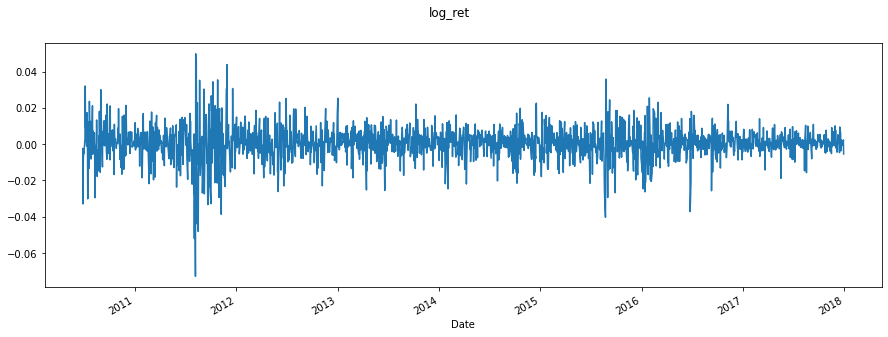

In [ ]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('log_ret')
df_train['log_ret'].plot()
plt.show()

## Two regimes, switching mean and variance

In [ ]:
hmm1 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_results = hmm1.fit(search_reps = 100)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
print(hmm1_results.summary())

                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 1889
Model:               MarkovRegression   Log Likelihood                6435.627
Date:                Thu, 03 Feb 2022   AIC                         -12859.254
Time:                        04:24:04   BIC                         -12825.991
Sample:                             0   HQIC                        -12847.005
                               - 1889                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.740      0.459      -0.002       0.001
sigma2         0.0002   1.35e-05     14.211      0.0

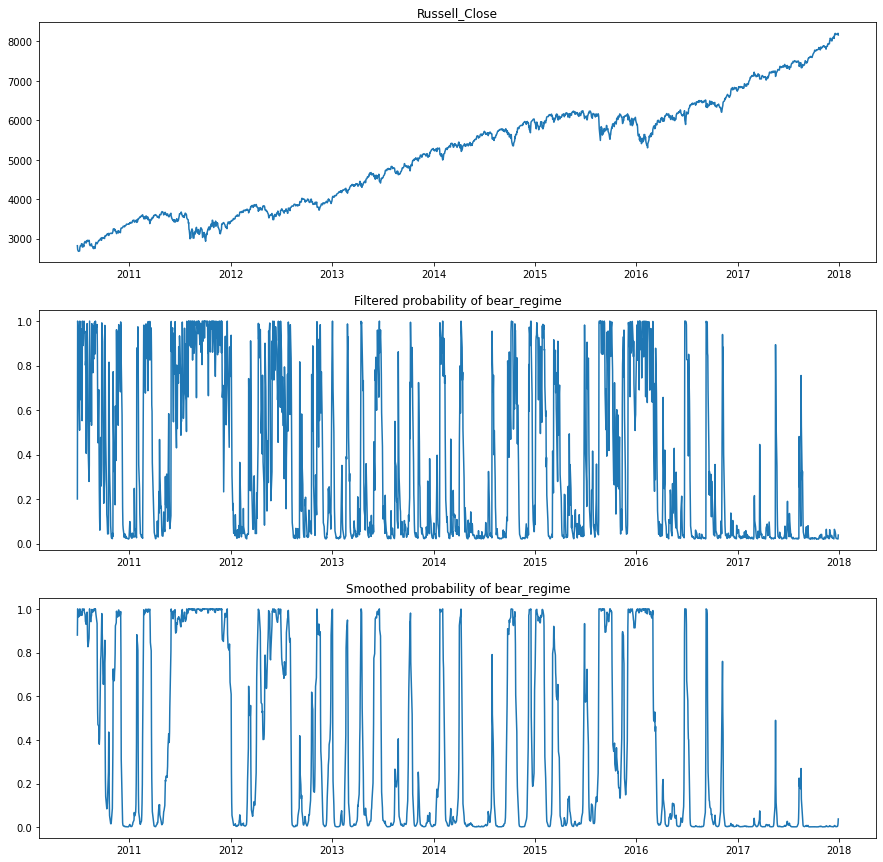

In [ ]:
bear_regime = 0 if hmm1_results.params['const[0]']<hmm1_results.params['const[1]'] else 1

fig, axes = plt.subplots(3, figsize=(15, 15))

ax = axes[0]
ax.plot(df_train.index, df_train['Russell_Close'])
ax.set(title='Russell_Close')
 
ax = axes[1]
ax.plot(df_train.index, hmm1_results.filtered_marginal_probabilities[bear_regime])
ax.set(title='Filtered probability of bear_regime')
 
ax = axes[2]
ax.plot(df_train.index, hmm1_results.smoothed_marginal_probabilities[bear_regime])
ax.set(title='Smoothed probability of bear_regime')

plt.show()

In [ ]:
#using the same probability filter constructed from the training set
hmm1_test = sm.tsa.MarkovRegression(endog=df_test['log_ret'], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


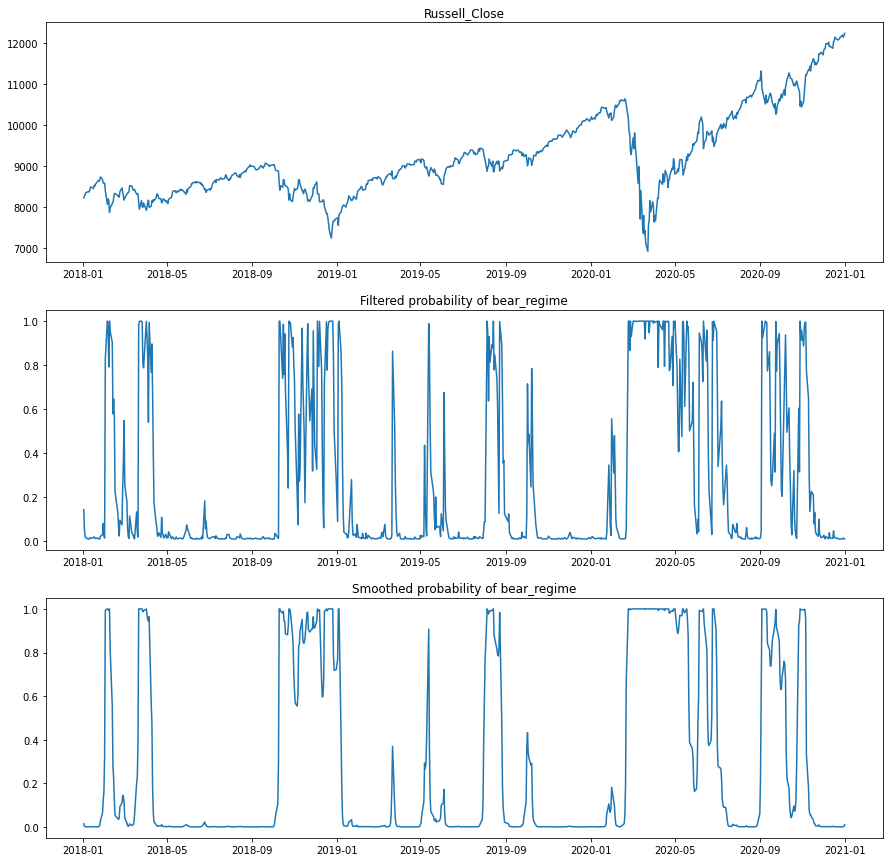

In [ ]:
bear_regime = 0 if hmm1_test_results.params[2]<hmm1_test_results.params[3] else 1

fig, axes = plt.subplots(3, figsize=(15, 15))

ax = axes[0]
ax.plot(df_test.index, df_test['Russell_Close'])
ax.set(title='Russell_Close')
 
ax = axes[1]
ax.plot(df_test.index, hmm1_test_results.filtered_marginal_probabilities[bear_regime])
ax.set(title='Filtered probability of bear_regime')
 
ax = axes[2]
ax.plot(df_test.index, hmm1_test_results.smoothed_marginal_probabilities[bear_regime])
ax.set(title='Smoothed probability of bear_regime')

plt.show()

In [ ]:
# Labeling on the data set

threshold1 = 0.8
threshold2 = 0.6
label_train_smoothed = []
label_train = []
label_test = []

for i in hmm1_results.smoothed_marginal_probabilities[bear_regime].values:
  if i >= threshold1:
    app = -1
  elif i >= threshold2:
    app = 0
  else:
    app = 1
  label_train_smoothed.append(app)

for i in hmm1_results.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold1:
    app = -1
  elif i >= threshold2:
    app = 0
  else:
    app = 1
  label_train.append(app)

for i in hmm1_test_results.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold1:
    app = -1
  elif i >= threshold2:
    app = 0
  else:
    app = 1
  label_test.append(app)

label_train_smoothed= np.array(label_train_smoothed)
label_train= np.array(label_train)
label_test= np.array(label_test)

label = np.concatenate((label_train, label_test), axis=0)
df['hmm1 filtered state'] = label

df_train, df_test = df[train_start:train_end],df[train_end:test_end]

In [ ]:
# The effectiveness of the labeling in terms of trading
print(df_train['log_ret'].sum())
print((df_train['log_ret'] * label_train_smoothed).sum(),(df_train['log_ret'] * label_train).sum())
print('=================================')
print(df_test['log_ret'].sum())
print((df_test['log_ret'] * label_test).sum())

1.0285128097676512
1.8800466279753518 1.1910379222276068
0.4205309960530421
1.338714462341711


In [ ]:
#train the whole data set to get smoothed label
hmm1_smoothed = sm.tsa.MarkovRegression(endog=df['log_ret'], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_smoothed_results = hmm1_smoothed.fit(search_reps = 100)
bear_regime = 0 if hmm1_smoothed_results.params[2]<hmm1_smoothed_results.params[3] else 1

# Labeling
threshold1 = 0.8
threshold2 = 0.6
label = []


for i in hmm1_smoothed_results.smoothed_marginal_probabilities[bear_regime].values:
  if i >= threshold1:
    app = -1
  elif i >= threshold2:
    app = 0
  else:
    app = 1
  label.append(app)

df['hmm1 smoothed state'] = label
df_train, df_test = df[train_start:train_end],df[train_end:test_end]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# The effectiveness of the labeling in terms of trading
print(df_train['log_ret'].sum())
print((df_train['log_ret'] * df_train['hmm1 smoothed state']).sum(),(df_train['log_ret'] * df_train['hmm1 filtered state']).sum())
print('=================================')
print(df_test['log_ret'].sum())
print((df_test['log_ret'] * df_test['hmm1 smoothed state']).sum(),(df_test['log_ret'] * df_test['hmm1 filtered state']).sum())

1.0285128097676512
2.076297253295026 1.1910379222276068
0.4205309960530421
1.1928083607529665 1.338714462341711


In [ ]:
df.to_csv(r'gdrive/My Drive/master_ds_v2_NoNA.csv')

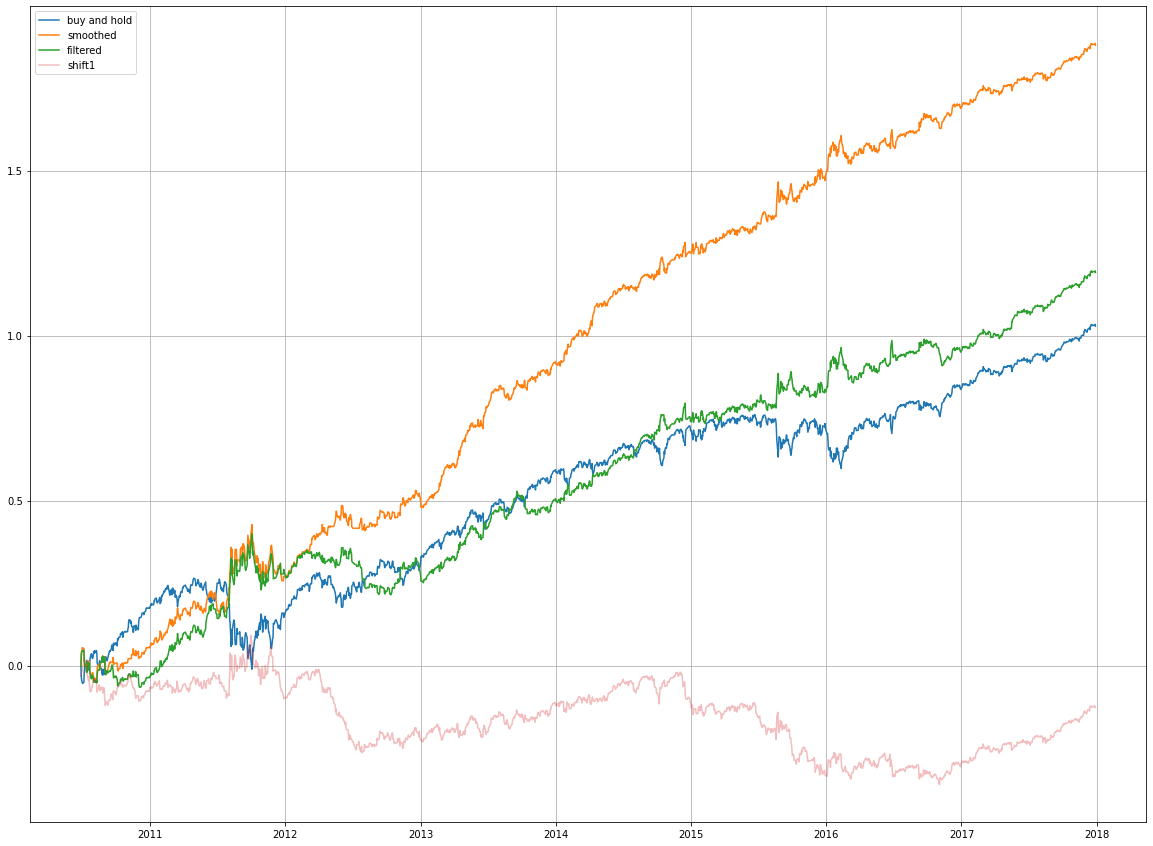

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_train_smoothed).cumsum(),label="smoothed")
ax.plot(df_train.index, (df_train['log_ret'] * label_train).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_train).cumsum(),label = "shift1",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

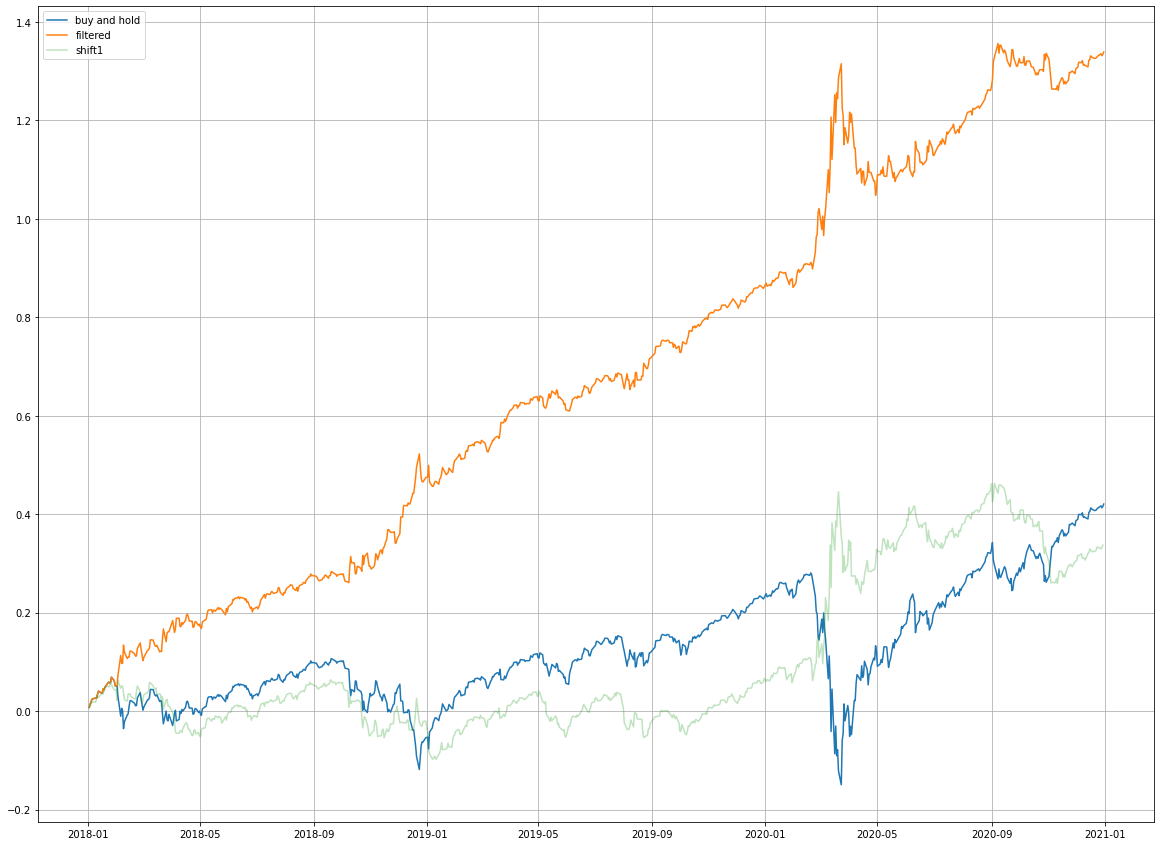

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_test).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_test).cumsum(),label = "shift1",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

## Two regimes, switching mean and variance with other dependent variables

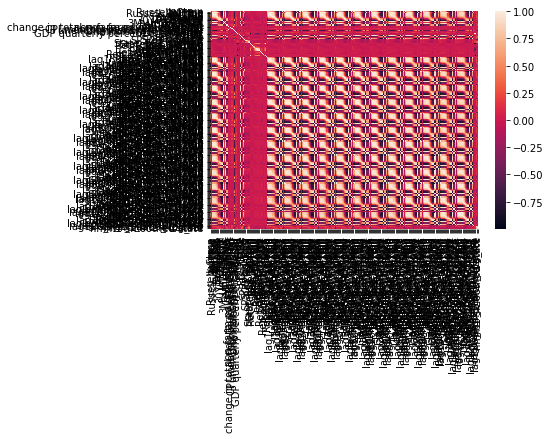

In [ ]:
import seaborn as sns
%matplotlib inline

Var_Corr = df.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

In [ ]:
df.columns

Index(['Russell_Close', 'Russell_Volume', '1MTBill', '3MTBill', '6MTBill',
       '1YTBill', '3YTNotes', '5YTNotes', '10YTNotes', '30YTTreasury',
       ...
       'lag120_Ret_T10Y3M', 'lag120_Ret_T10Y2Y', 'lag120_Ret_3M_USD_LIBOR',
       'lag120_Ret_WTI_Futures', 'lag120_Ret_WTI_Spot',
       'lag120_Ret_SP500_Close', 'lag120_Ret_SP500_Volume', 'log_ret',
       'hmm1 filtered state', 'hmm1 smoothed state'],
      dtype='object', length=248)

In [ ]:
tvtp_var = [ '3MTBill','10YTNotes','WTI_Futures']

In [ ]:
df_train_tvtp = df_train[tvtp_var]
df_train_tvtp = df_train_tvtp.dropna()
df_train_tvtp=(df_train_tvtp-df_train_tvtp.mean())/df_train_tvtp.std()
df_train_tvtp['ones'] = 1
df_train_tvtp.dtypes

3MTBill        float64
10YTNotes      float64
WTI_Futures    float64
ones             int64
dtype: object

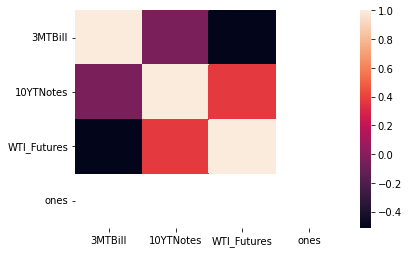

In [ ]:
Var_Corr = df_train_tvtp.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

In [ ]:
hmm2 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c',
                                    switching_variance=True,exog_tvtp = df_train_tvtp)
hmm2_results = hmm2.fit(search_reps = 100)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
print(hmm2_results.summary())

                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 1889
Model:               MarkovRegression   Log Likelihood                6446.362
Date:                Thu, 03 Feb 2022   AIC                         -12868.725
Time:                        04:21:07   BIC                         -12802.199
Sample:                             0   HQIC                        -12844.227
                               - 1889                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.642      0.521      -0.001       0.001
sigma2         0.0002   1.32e-05     14.069      0.0

In [ ]:
hmm2_results.params['const[0]']

-0.00034375646254008937

KeyError: ignored

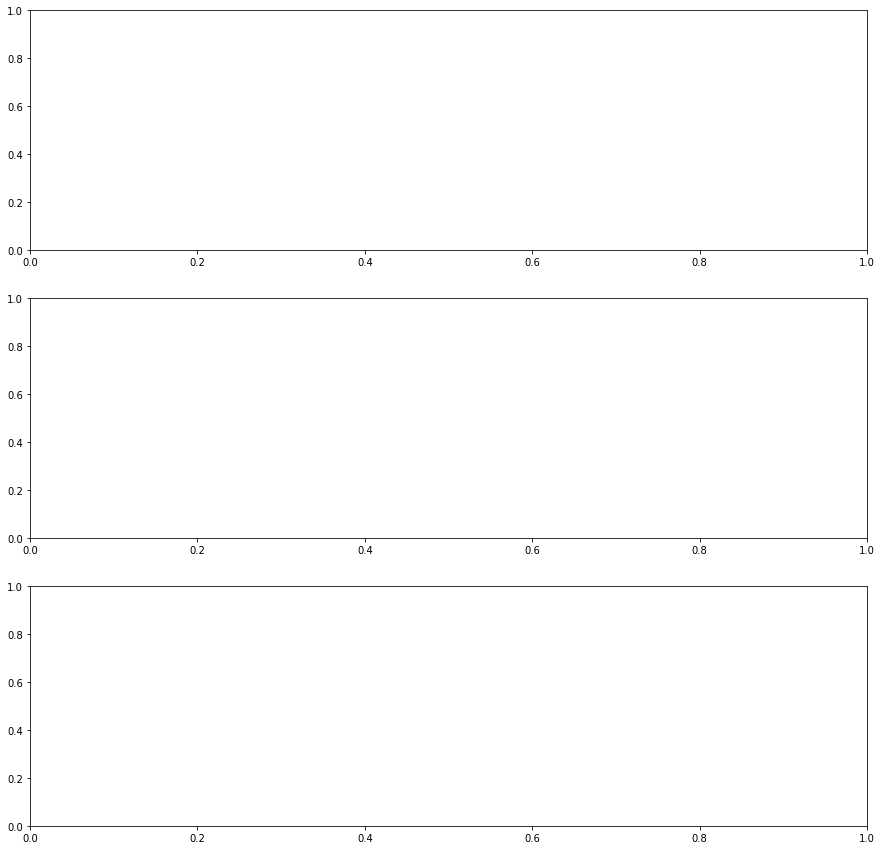

In [ ]:
bear_regime = 0 if hmm2_results.params['const[0]']<hmm2_results.params['const[1]'] else 1

fig, axes = plt.subplots(3, figsize=(15, 15))

ax = axes[0]
ax.plot(df_train.index, df_train['PX_LAST'])
ax.set(title='PX_LAST')
 
ax = axes[1]
ax.plot(df_train.index, hmm2_results.filtered_marginal_probabilities[bear_regime])
ax.set(title='Filtered probability of bear_regime')
 
ax = axes[2]
ax.plot(df_train.index, hmm2_results.smoothed_marginal_probabilities[bear_regime])
ax.set(title='Smoothed probability of bear_regime')

plt.show()

In [ ]:
df_test_tvtp = df_test[tvtp_var]
df_test_tvtp = df_test_tvtp.dropna()
df_test_tvtp=(df_test_tvtp-df_test_tvtp.mean())/df_test_tvtp.std()
df_test_tvtp['ones'] = 1
df_test_tvtp.dtypes

In [ ]:
#using the same probability filter constructed from the training set
hmm2_test = sm.tsa.MarkovRegression(endog=df_test['log_ret'], k_regimes=2,trend='c',
                                    switching_variance=True,exog_tvtp = df_test_tvtp)
hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)

In [ ]:
fig, axes = plt.subplots(3, figsize=(15, 15))

ax = axes[0]
ax.plot(df_test.index, df_test['PX_LAST'])
ax.set(title='PX_LAST')
 
ax = axes[1]
ax.plot(df_test.index, hmm2_test_results.filtered_marginal_probabilities[bear_regime])
ax.set(title='Filtered probability of bear_regime')
 
ax = axes[2]
ax.plot(df_test.index, hmm2_test_results.smoothed_marginal_probabilities[bear_regime])
ax.set(title='Smoothed probability of bear_regime')

plt.show()

In [ ]:
# Labeling on the data set

threshold = 0.7
label_train_smoothed = []
label_train = []
label_test = []

for i in hmm2_results.smoothed_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = -1
  elif i >= 1-threshold:
    app = 0
  else:
    app = 1
  label_train_smoothed.append(app)

for i in hmm2_results.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = -1
  elif i >= 1-threshold:
    app = 0
  else:
    app = 1
  label_train.append(app)

for i in hmm2_test_results.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = -1
  elif i >= 1-threshold:
    app = 0
  else:
    app = 1
  label_test.append(app)

label_train_smoothed= np.array(label_train_smoothed)
label_train= np.array(label_train)
label_test= np.array(label_test)
df_train['hmm2 state'] = label_train
df_test['hmm2 state'] = label_test

In [ ]:
# The effectiveness of the labeling in terms of trading
print(df_train['log_ret'].sum())
print((df_train['log_ret'] * label_train_smoothed).sum(),(df_train['log_ret'] * label_train).sum())
print('=================================')
print(df_test['log_ret'].sum())
print((df_test['log_ret'] * label_test).sum())

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_train_smoothed).cumsum(),label="smoothed")
ax.plot(df_train.index, (df_train['log_ret'] * label_train).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_train).cumsum(),label = "shift1",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_test).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_test).cumsum(),label = "shift1",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [ ]:
df_train.describe().transpose()

In [ ]:
plt.hist(df_train['hmm1 state'])

In [ ]:
plt.hist(df_train['hmm2 state'])

In [ ]:
sm.graphics.tsa.plot_acf(df_train['log_ret'].values.squeeze(), lags=10)
plt.show()

In [ ]:
sm.graphics.tsa.plot_pacf(df_train['log_ret'].values.squeeze(), lags=10)
plt.show()

Default
(endog, k_regimes, order, trend='c', exog=None, exog_tvtp=None, switching_ar=True, switching_trend=True, switching_exog=False, switching_variance=False, dates=None, freq=None, missing='none')

In [ ]:
hmm_ar1 = sm.tsa.MarkovAutoregression(
    df_train['log_ret'], k_regimes=2, order=5, switching_ar=True, 
    switching_variance=True,exog_tvtp = df_train_tvtp)
hmm_ar1_results = hmm_ar1.fit()

In [ ]:
print(hmm_ar1_results.summary())

In [ ]:
hmm_ar1.order

In [ ]:
bear_regime = 0 if hmm_ar1_results.params['const[0]']<hmm_ar1_results.params['const[1]'] else 1

fig, axes = plt.subplots(3, figsize=(15, 15))

ax = axes[0]
ax.plot(df_train.index, df_train['PX_LAST'])
ax.set(title='PX_LAST')
 
ax = axes[1]
ax.plot(df_train[hmm_ar1.order:].index, hmm_ar1_results.filtered_marginal_probabilities[bear_regime])
ax.set(title='Filtered probability of bear_regime')
 
ax = axes[2]
ax.plot(df_train[hmm_ar1.order:].index, hmm_ar1_results.smoothed_marginal_probabilities[bear_regime])
ax.set(title='Smoothed probability of bear_regime')

plt.show()

In [ ]:
#using the same probability filter constructed from the training set
hmm_ar1_test = sm.tsa.MarkovAutoregression(df_test['log_ret'], k_regimes=2, order=5, switching_ar=True, 
    switching_variance=True,exog_tvtp = df_test_tvtp)
hmm_ar1_test_results = hmm_ar1_test.fit(start_params = hmm_ar1_results.params, maxiter = 0)

In [ ]:
fig, axes = plt.subplots(3, figsize=(15, 15))

ax = axes[0]
ax.plot(df_test.index, df_test['PX_LAST'])
ax.set(title='PX_LAST')
 
ax = axes[1]
ax.plot(df_test[hmm_ar1.order:].index, hmm_ar1_test_results.filtered_marginal_probabilities[bear_regime])
ax.set(title='Filtered probability of bear_regime')
 
ax = axes[2]
ax.plot(df_test[hmm_ar1.order:].index, hmm_ar1_test_results.smoothed_marginal_probabilities[bear_regime])
ax.set(title='Smoothed probability of bear_regime')

plt.show()

In [ ]:
# Labeling on the data set

threshold = 0.7
label_train_smoothed = []
label_train = []
label_test = []

for i in hmm_ar1_results.smoothed_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = -1
  elif i >= 1-threshold:
    app = 0
  else:
    app = 1
  label_train_smoothed.append(app)

for i in hmm_ar1_results.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = -1
  elif i >= 1-threshold:
    app = 0
  else:
    app = 1
  label_train.append(app)

for i in hmm_ar1_test_results.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = -1
  elif i >= 1-threshold:
    app = 0
  else:
    app = 1
  label_test.append(app)

label_train_smoothed= np.array(label_train_smoothed)
label_train= np.array(label_train)
label_test= np.array(label_test)
#df_train['hmm_ar1 state'] = label_train
#df_test['hmm_ar1 state'] = label_test

In [ ]:
# The effectiveness of the labeling in terms of trading
print(df_train['log_ret'].sum())
print((df_train['log_ret'][hmm_ar1.order:] * label_train_smoothed).sum(),(df_train['log_ret'][hmm_ar1.order:] * label_train).sum())
print('=================================')
print(df_test['log_ret'].sum())
print((df_test['log_ret'][hmm_ar1.order:] * label_test).sum())

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))


ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train[hmm_ar1.order:].index, (df_train['log_ret'][hmm_ar1.order:] * label_train_smoothed).cumsum(),label="smoothed")
ax.plot(df_train[hmm_ar1.order:].index, (df_train['log_ret'][hmm_ar1.order:] * label_train).cumsum(),label = "filtered")
ax.plot(df_train[hmm_ar1.order:].index, (df_train['log_ret'][hmm_ar1.order:].shift(-1) * label_train).cumsum(),label = "shift1",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test[hmm_ar1.order:].index, df_test['log_ret'][hmm_ar1.order:].cumsum(),label="buy and hold")
ax.plot(df_test[hmm_ar1.order:].index, (df_test['log_ret'][hmm_ar1.order:] * label_test).cumsum(),label = "filtered")
ax.plot(df_test[hmm_ar1.order:].index, (df_test['log_ret'][hmm_ar1.order:].shift(-1) * label_test).cumsum(),label = "shift1",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()